# Interpolation

**Note:**
Due to updates in SciPy (which probably happened a long time ago, but, I have been using this system for an even longer time and thus have not kept up with all changes) the way in which we will discuss and use interpolation has changed.
This means this notebook **will be updated** between now and when we complete our discussion of it.
Once fully updated this note will be removed.
The update(s) will be pushed to github (the canvas link takes us to this file) so it will be necessary to download this file again at some point.
Once fully updated this note will be removed.

Here we will perform a quick exploration of some of the interpolation routines (mostly) available in `scipy.interpolate`.
As always there is much more available than we will use here.
You should explore some of the other functions on your own.

## Initialization

As always we load all the modules we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

# We will use random numbers in this example, so like we saw earlier ...
rng = np.random.default_rng()

## Documentation

Again as always we should explore the documentation to learn more about the functions that are available for us.
In this case SciPy does provide a [User Guide for Interpolation](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html) external to the local documentation.
This suggests for one dimensional interpolations (all we will discuss) we should use the `np.interp()` for a piecewise linear interpolating function, and `scipy.interpolate.CubicSpline` for cubic splines.
More generally we can use `scipy.interpolate.make_interp_spline()` for a general spline.
The `scipy.interpolate.interp1d` function is marked as *legacy*, though it will still exist, will have been used in countless examples (found online), and is still reasonable to use in specific cases.
What is not discussed in this guide are `lagrange` and `InterpolatedUnivariateSpline`.
We will use `lagrange` to construct the Lagrange interpolating polynomial.
In the past I have made extensive use of `InterpolatedUnivariateSpline` though perhaps that should change!

Overall this shows part of the danger of relying on a single source and just searching for answers.
We can find a lot of code online and/or have code written for us, such as by AI, but that does not mean we should blindly use it.
Particularly in this course we need to *understand* what the code does and why a particular approach is used.
For this reason, we still have documentation to explore.

We begin with `scipy.interpolate`.

In [ ]:
interp?

For linear piecewise interpolation it was suggested to use `np.interp()`.
For better or worse, this is called differently than other methods of interpolating.
This function does the interpolation and returns the result, it does not return an object that can be used for subsequent interpolations!

In [ ]:
np.interp?

We can construct the Lagrange interpolating polynomial.
Note that it warns you that the implementation is unstable for $N\approx 20$.

In [ ]:
interp.lagrange?

The legacy `interp1d` interface still exists and will still be found "in the wild" so it is good to know what it does.

In [ ]:
interp.interp1d?

For splines there are a number of possibilities.
We will explore these as we go along.
The object that is returned by `InterpolatedUnivariateSpline` and `make_interp_spline` (and thus also `CubicSpline`) are very similar but not identical.
Though `InterpolatedUnivariateSpline` has a few more attributes/methods, going forward I think I will recommend and always use `make_interp_spline`.

In [ ]:
interp.InterpolatedUnivariateSpline?

In [ ]:
interp.CubicSpline?

In [ ]:
interp.make_interp_spline?

The main things to pay attention to while looking at these functions are
1. what they do,
2. how they are called, including optional arguments,
3. constraints on the arguments, that is, any special conditions that must be satisfied,
4. what they return and any constraints on them.

## Simple Interpolation

Here we will consider the function
$$ f(x) = \frac{1}{1 + 25 x^2}, $$
a scaled version of the Witch of Agnesi.

We begin using `interp1d` to do a number of different piecewise polynomial interpolations.

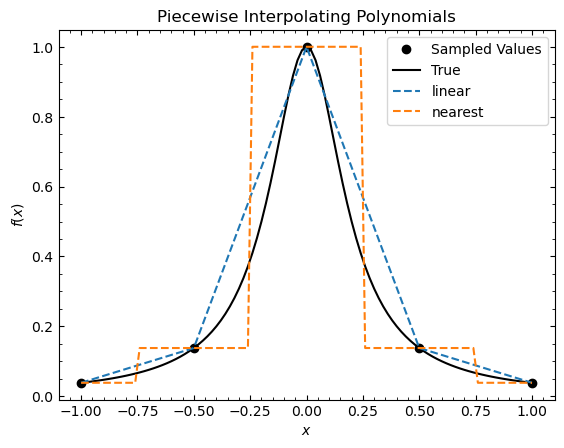

In [2]:
def f(x):
    return 1 / (1 + 25 * x**2)

N = 5
xarr = np.linspace(-1, 1, N)
yarr = f(xarr)
xfine = np.linspace(-1, 1, 101)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xarr, yarr, 'ko', label='Sampled Values')
ax.plot(xfine, f(xfine), 'k-', label='True')

interp_linear = np.interp(xfine, xarr, yarr)
interp_nearest = interp.interp1d(xarr, yarr, kind='nearest')
ax.plot(xfine, interp_linear, '--', label='linear')
ax.plot(xfine, interp_nearest(xfine), '--', label='nearest')
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Piecewise Interpolating Polynomials');

## Runge's Phenomenon

Above we used a piecewise polynomial (really a spline) which improves as we increase the number of points. What if we instead use a single polynomial, the Lagrange interpolating polynomial?
Here we compare it to the piecewise cubic polynomial.

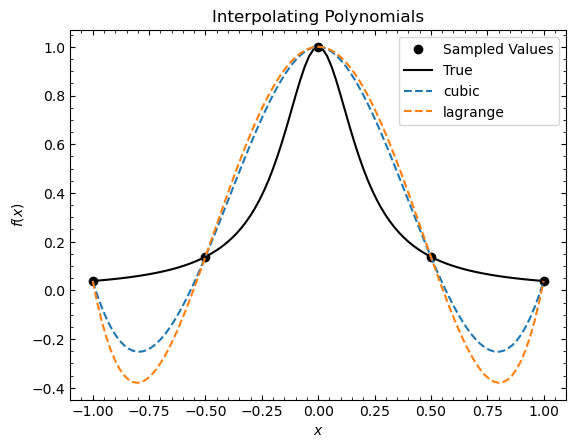

In [3]:
N = 5
xarr = np.linspace(-1, 1, N)
yarr = f(xarr)
xfine = np.linspace(-1, 1, 101)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xarr, yarr, 'ko', label='Sampled Values')
ax.plot(xfine, f(xfine), 'k-', label='True')

# Here we will just use a cubic spline as an example of piecewise polynomial.
# Splines will be discussed more below. Here we just want it for comparison.
interp_cubic = interp.make_interp_spline(xarr, yarr)
interp_lagrange = interp.lagrange(xarr, yarr)
ax.plot(xfine, interp_cubic(xfine), '--', label='cubic')
ax.plot(xfine, interp_lagrange(xfine), '--', label='lagrange')
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Interpolating Polynomials');

We see that as the number of points increases the cubic interpolation improves, but the Lagrange interpolating polynomial gets worse with very wild oscillations.
This was discovered by Runge when exploring the errors in the use of interpolating polynomials.
This function is one of the classic examples how when it is a big problem.
It is related to Gibbs phenomenon in Fourier analysis.
It occurs when the points are equally spaced and is one reason why the Lagrange interpolating polynomial, at least with equally spaced points, can behave badly.

## Chebyshev Nodes

How can we improve this?
As stated, uniformly sampling is often poor, a better approach is to sample the points differently.
It turns out that if we sample using the zeros of a Chebyshev polynomial we can much more accurately represent the function, even with the Lagrange interpolating polynomial.
The Chebyshev polynomials are have many uses in numerial analysis.
Unfortunately we will not have an opportunity to study them in any detail.
Here all we need to know is that for $N$ points the zeros of the $N^{\mathrm{th}}$ Chebyshev polynomial of the first kind, $T_N(x)$, are
$$ x_k = \cos\!\left( \frac{2 k + 1}{2n} \pi \right), $$
for $k = 0, \ldots, N-1$.

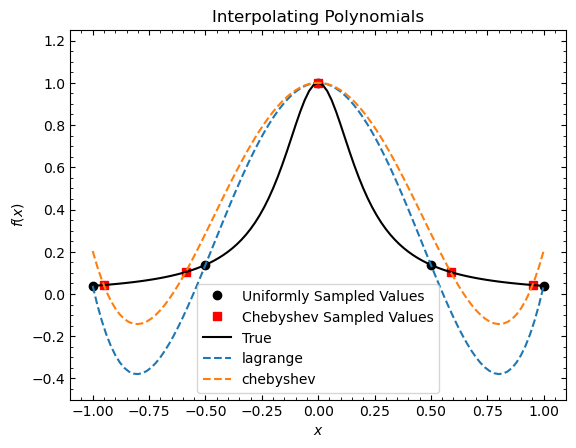

In [4]:
N = 5
xarr = np.linspace(-1, 1, N)
yarr = f(xarr)
xCheb = np.cos((2*np.arange(N) + 1) * np.pi / (2 * N))
yCheb = f(xCheb)
xfine = np.linspace(-1, 1, 101)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xarr, yarr, 'ko', label='Uniformly Sampled Values')
ax.plot(xCheb, yCheb, 'rs', label='Chebyshev Sampled Values')
ax.plot(xfine, f(xfine), 'k-', label='True')

ax.set_ylim(-0.5, 1.25)
interp_uniform = interp.lagrange(xarr, yarr)
interp_Cheb = interp.lagrange(xCheb, yCheb)
ax.plot(xfine, interp_uniform(xfine), '--', label='lagrange')
ax.plot(xfine, interp_Cheb(xfine), '--', label='chebyshev')
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Interpolating Polynomials');

## Comparisons

Here we will perform another comparison of polynomial interpolation with a cubic spline using randomly generated points.
It is interesting to vary the number of points, `N`, and see how the two methods compare.
We might expect that for very few points interpolation does a poor job since not much structure about the function we are interpolating is known.
As the number of points is increased it may be expected that interpolation does a better job.
To an extent this is true, however as `N` gets somewhat large (say near 20 or so) the polynomial interpolation can fail spectacularly.
Evaluating a high order polynomial is not easy due to the limited precision of computers.
The spline **does improve** as `N` increases since it is doing a piecewise interpolation.

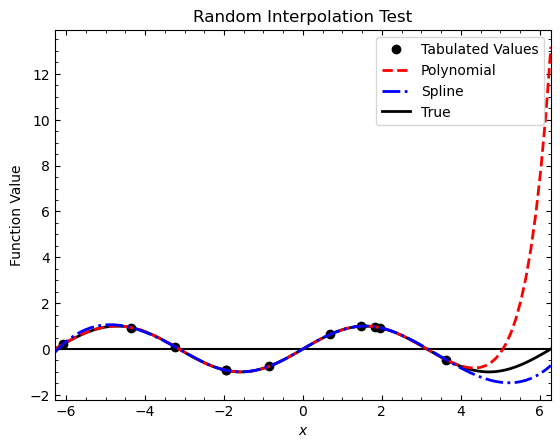

In [5]:
N = 11  # Number of points to generate
xmax = 2 * np.pi
x = (2 * rng.random(N) - 1) * xmax
x.sort()  # We need the x values to be monotonic, so sort them
y = np.sin(x)

# Use polynomial interpolation and a spline
ypoly = interp.lagrange(x, y)
yspline = interp.make_interp_spline(x, y)

# For plotting purpose we generate a fine grid
xx = np.linspace(-xmax, xmax, 100)
ytrue = np.sin(xx)

# Now make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.plot(x, y, 'ko', label='Tabulated Values')
ax.plot(xx, ypoly(xx), 'r--', lw=2, label='Polynomial')
ax.plot(xx, yspline(xx), 'b-.', lw=2, label='Spline')
ax.plot(xx, ytrue, 'k-', lw=2, zorder=-1, label='True')
ax.set_xlim(xx[0], xx[-1])
# ax.set_ylim(-1.5, 1.5)
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel('Function Value')
ax.set_title('Random Interpolation Test');

In [6]:
print(ypoly)

          10             9             8             7             6
1.39e-07 x  + 2.402e-06 x - 3.404e-06 x - 0.0001984 x + 2.684e-05 x
             5             4          3             2
 + 0.008345 x - 9.124e-05 x - 0.1667 x + 0.0001305 x + 1 x - 5.129e-05


Overall we find for "moderate" values of `N` both the polynomial and spline work well where the function is well sampled, though the polynomial often better reprents the true function. In places where it is not or at the ends when the interpolants are extrapolated neither tend to perform well. This is generic issue with interpolation!

## Inverting a Function

A very powerful use of interpolation is to invert a function. We typically think of a function as $y = f(x)$, given $x$ we wish to calculate $y$. With interpolation, we start with tabulated values for $x$ and $y$ and estimate values of the function at $x$ values in between the tabulated ones. However, we can just as well invert this and instead consider $x=f^{-1}(y)$. This is *exactly the same problem* just with the roles of $x$ and $y$ reversed.

Here we will consider inverting a simple function: $y=\mathrm{e}^{-x/3}$. We know the result in this case, $x=-3\ln(y)$.

First define our function and its inverse.

In [7]:
def f(x):
    return np.exp(-x / 3.)
def finv(y):
    return -3. * np.log(y)

Next we perform a simple test to verify that interpolation does a good job of representing our function. Since this is a quick test we use a "quick plot" and do not make it look nice.

Maximum fractional error = 0.017842407358762635


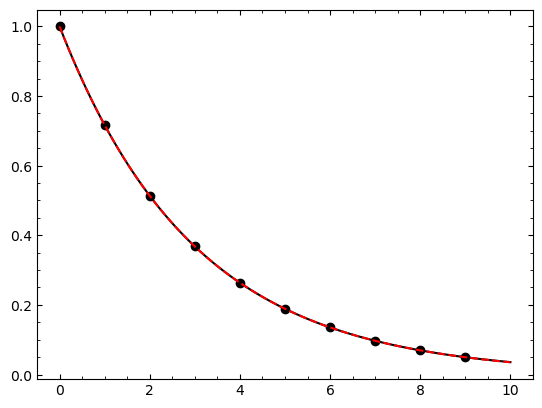

In [8]:
x = np.arange(10.)
y = f(x)
yspline = interp.make_interp_spline(x, y)
xx = np.linspace(0, 10, 100)
ytrue = f(xx)
plt.plot(x, y, 'ko')
plt.plot(xx, ytrue, 'k-')
plt.plot(xx, yspline(xx), 'r--')
print("Maximum fractional error =", np.abs(1 - yspline(xx) / ytrue).max())

Since that works let us try to use a spline to invert the function. As noted about this just means swapping $x$ and $y$.

In [9]:
yinvspline_fail = interp.make_interp_spline(y, x)

ValueError: Expect x to be a 1D strictly increasing sequence.

It fails to run. This is an improvement over old versions of `scipy.interpolate`! In the past it would silently create the spline, but then for *some values* of `y` it would return `nan`! It even tells us why it failed.

To understand what is happening go back to the documenation for `InterpolatedUnivariateSpline`. Notice that the first argument **must be increasing**. This is a peculiar limitation of the interface provided by `scipy.interpolate`. Regardless, it is documented and if you check our `y` array you will find it is actually decreasing, not increasing. Thus we need to invert the order of the array. How do we do this?

A very powerful feature of array processing languages such as the one provided by NumPy is *array slicing*. We will have more to say about this in the future but for now we will note that when accessing the elements of an array we can use
> `y[start:stop:step]`

to get a view of a subset of the array. This is similar to using `arange` to generate a list of index values inside the square brackets (similar, but not the same).

For our purposes we want to reverse the order of the array and will leave the details for the future. This means we want to start at the end of the array and step backwards through it to get to the beginning. The shorthand way to do this is `y[::-1]`.

First verify this actually works.

In [10]:
print('y =', y)
print('y[::-1] =', y[::-1])

y = [1.         0.71653131 0.51341712 0.36787944 0.26359714 0.1888756
 0.13533528 0.09697197 0.06948345 0.04978707]
y[::-1] = [0.04978707 0.06948345 0.09697197 0.13533528 0.1888756  0.26359714
 0.36787944 0.51341712 0.71653131 1.        ]


Now use this to construct a spline of the inverted function. Note that since we are inverting the order of `y` we must also invert the order of `x`! This now works much better.

In [11]:
yinvspline = interp.make_interp_spline(y[::-1], x[::-1])
ytry = 0.2
print('For y =', ytry, 'true inverse is', finv(ytry), 'and our spline gives', yinvspline(ytry))

For y = 0.2 true inverse is 4.828313737302301 and our spline gives 4.828333687151295


We can create a quick plot to verify it works over a broader range of values.

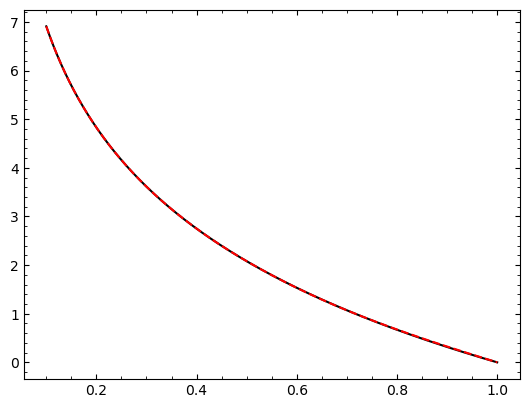

In [12]:
yy = np.linspace(0.1, 1, 1000)
plt.plot(yy, finv(yy), 'k-')
plt.plot(yy, yinvspline(yy), 'r--')